In [5]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from cooc import *
#rom glove_template import *
from pickle_vocab import *

In [7]:
with open('twitter-datasets/train_pos.txt') as f:
    pos = f.readlines()

In [8]:
with open('twitter-datasets/train_neg.txt') as f:
    neg = f.readlines()

In [9]:
train=pos+neg

In [10]:
train_target=[':)']*len(pos)+[':(']*len(neg)

In [12]:
full_train={'data':train,
           'target':train_target}
full_train=pd.DataFrame(full_train)
full_train.sample(5)

,data,target
13122,<user> yes i have ! sorry i haven't messaged y...,:)
165724,"tool steel a2 rectangular bar , oversized , as...",:(
150767,<user> colton elise needs to go ! ! !\n,:(
8198,"errtime #oomf text me , i get this big goofy s...",:)
141096,<user> good man . <user> and i arrived at wate...,:(


# Data exploration

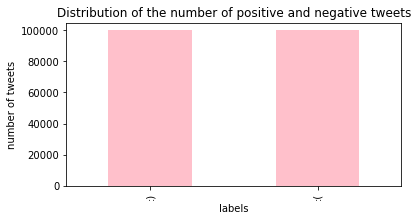

In [14]:
full_train['target'].value_counts().plot.bar(color = 'pink', figsize = (6, 3))
plt.title("Distribution of the number of positive and negative tweets")
plt.ylabel("number of tweets")
plt.xlabel("labels")
plt.show()

The number of tweets per label (positive or negative) is the same. 

In [15]:
full_train.groupby('target').describe()

data                                                                
         count unique                                                top  freq
target                                                                        
:(      100000  91088  i just wrote this ( tell me what you think <ur...   335
:)      100000  90233  i love our fans ! there all so beautiful ! x <...  1536

As already stated above, there is the same number of positive and negative tweets (100'000). In both sets, we have some duplicated tweets as the number of unique tweets for **:(** and for **:)** labels is inferior to 100'000 and it seems that there are more duplicates for the **:)** label. Moreover, the two tweets (one per label) that are the most frequent, have frequency of 335 for **:(** and 1536 for **:)**.  

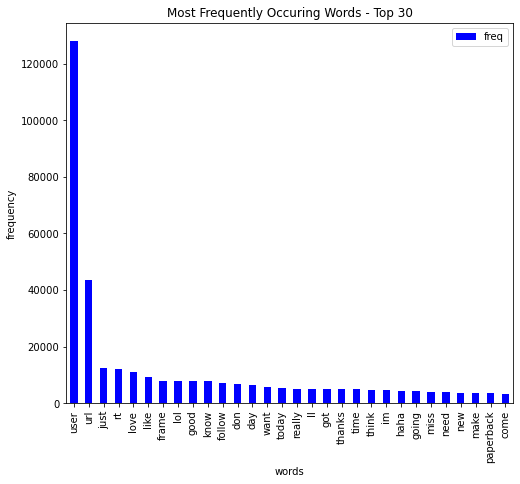

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

##Let's have a look at the words
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(full_train.data)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(8, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")
plt.xlabel('words')
plt.ylabel('frequency')
plt.show()

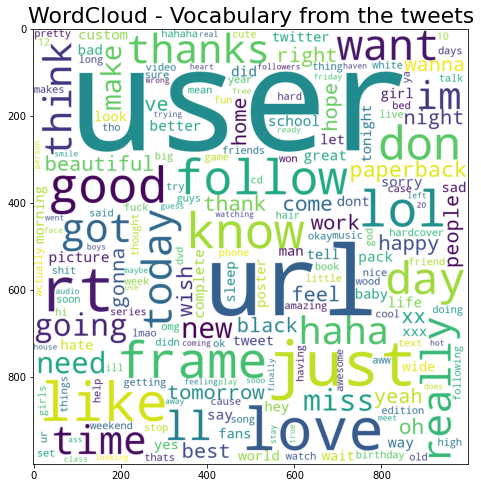

In [29]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from the tweets", fontsize = 22)
plt.show()

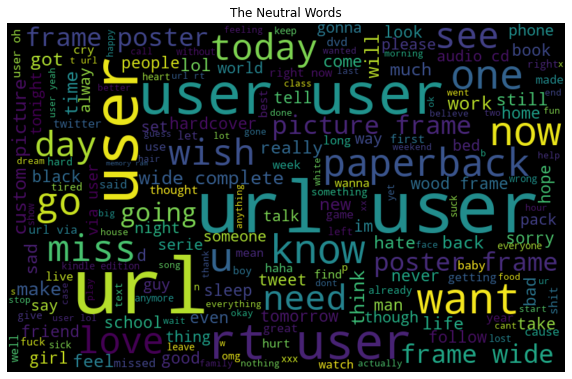

In [32]:

normal_words =' '.join([text for text in train['data'][train['target'] == ':(']])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

#### Split the data

In [30]:
from sklearn.model_selection import train_test_split

train , test=train_test_split(full_train)

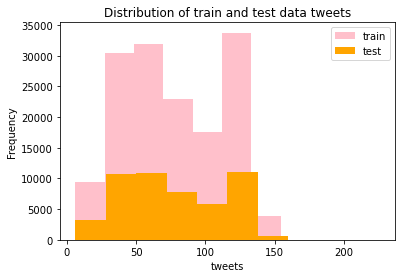

In [33]:
length_train = train['data'].str.len().plot.hist( color = 'pink', figsize = (6, 4), label="train")
length_test = test['data'].str.len().plot.hist(test, color = 'orange', figsize = (6, 4), label="test")
plt.legend(loc='upper right')
plt.xlabel("tweets")
plt.title("Distribution of train and test data tweets")
plt.show()

### Bayes Classifier

In [34]:
# Extracting features from text files

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.data)
X_train_counts.shape

(150000, 85045)

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(150000, 85045)

In [36]:
from sklearn.naive_bayes import MultinomialNB

# Training Naive Bayes (NB) classifier on training data.
clf = MultinomialNB().fit(X_train_tfidf, train.target)

In [37]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(train.data, train.target)

In [38]:
predicted = text_clf.predict(test.data)
np.mean(predicted == test.target)

0.7643

### SVM

In [39]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(train.data, train.target)
predicted_svm = text_clf_svm.predict(test.data)
np.mean(predicted_svm == test.target)

0.81124

### Trying models Alex (doesn't work because of float)


In [19]:
maxs = []
for elem in train:
    maxs.append(len(elem.split(" ")))
max_ = max(maxs)

In [98]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train.data, train.target, test_size = 0.25, random_state = 42)
#train.data, test.data, train.target ...

In [99]:
def create_sequences(max_, train, test):
    # fit train words to tokenizer
    tokenizer.fit_on_texts(train)
    # get words and their indexes
    word_index = tokenizer.word_index
    # number of words
    nb_word = len(word_index)
    print(nb_word)
    # transform text to sequence
    X_sequences = tokenizer.texts_to_sequences(train)
    test_sequences = tokenizer.texts_to_sequences(test)
    
    # Pad sequences
    X_sequences = sequence.pad_sequences(X_sequences, maxlen=30,padding='pre')
    test_sequences = sequence.pad_sequences(test_sequences, maxlen=30,padding='pre')

    # create y, first pos then neg
    train_size = len(train)
    y = np.array(int(train_size/2) * [1] + int(train_size/2) * [0])

    # create indices 
    indices = np.arange(X_sequences.shape[0])
    np.random.shuffle(indices)
    X_sequences = X_sequences[indices]
    y = y[indices]
    print("Sequences created!") 
    return X_sequences, test_sequences, y, nb_word, word_index


X_sequences, test_sequences, y, nb_word, word_index = create_sequences(max_,train, test)

NameError: name 'tokenizer' is not defined

In [21]:
def create_glove_matrix(word_embedding, train, nb_word):
    '''
    This method creates an embedding matrix from a dict passed in argument
    '''
    X_splitted = [x.split() for x in train]

    glove_matrix = np.zeros((nb_word + 1, 200))
    for word, i in word_index.items():
        embedding_vector = word_embedding.get(word.encode())
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            glove_matrix[i] = embedding_vector
    print('Matrix created')
    
    return glove_matrix

In [71]:
glove_matrix = create_glove_matrix(glove_template.row, train ,nb_word)

NameError: name 'glove_template' is not defined

In [63]:
# tokenizing the words present in the training set
tokenized_tweet = train['data'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['data']), epochs=20)

(34440803, 47185960)

In [201]:
#Other way of splitting
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train.data, train.target, test_size = 0.25, random_state = 42)
#train.data, test.data, train.target, test.target
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(112500,)
(37500,)
(112500,)
(37500,)


In [202]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(train.data)
x_valid = sc.transform(test.data)

ValueError: could not convert string to float: 'rt if you have won us finals so far this season .\n'

In [82]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(train.data, train.target)

y_pred = model.predict(test.data)

print("Training Accuracy :", model.score(train.data, train.target))
print("Validation Accuracy :", model.score(test.data, test.target))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(test.target, y_pred))

# confusion matrix
cm = confusion_matrix(test.target, y_pred)
print(cm)

ValueError: could not convert string to float: 'rt if you have won us finals so far this season .\n'

In [83]:
Logistic Regression

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train.data, train.target)

y_pred = model.predict(test.data)

print("Training Accuracy :", model.score(train.data, train.target))
print("Validation Accuracy :", model.score(test.data, test.target))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(test.target, y_pred))

# confusion matrix
cm = confusion_matrix(test.target, y_pred)
print(cm)

ValueError: could not convert string to float: 'rt if you have won us finals so far this season .\n'

## Trying something with the file generated from glove_template

In [204]:
#loading the data
embedding = np.load('embeddings.npy')
embedding

array([[ 0.22640361, -0.40024342,  0.14873088, ..., -0.34243433,
         0.24890988,  0.01761889],
       [ 0.28307899, -0.53898438,  0.17432014, ..., -0.46657558,
         0.26930201,  0.03843433],
       [ 0.36069745, -0.61174519,  0.20528002, ..., -0.51441128,
         0.29707903,  0.01627219],
       ...,
       [ 1.32456955, -1.10948019,  0.08538186, ..., -0.0783017 ,
        -0.61777957, -0.41361194],
       [ 1.28636033,  0.55541084, -1.43948695, ..., -0.11769803,
        -0.39038506, -1.718321  ],
       [ 0.34752891,  0.58156755,  0.4432093 , ...,  0.01954502,
        -1.43372399,  1.51159475]])

In [205]:
#Associate embedding with vocab words but we should do a cleaning of the vocab first such as remove word "user"
#Remove punctuations...

vocab = pickle.load(open('vocab.pkl', "rb")) #this file was generated by executing vocab.sh
word_embedding = {}
for key in vocab.keys():
    word_embedding[key] = embedding[vocab.get(key)] # keys in this dict are not encoded 

In [188]:
word_embedding_ = pd.DataFrame(word_embedding).T
word_embedding_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
<user>,0.226404,-0.400243,0.148731,-0.309545,0.437378,0.213579,0.086634,0.117222,-0.031624,-0.189807,0.075544,0.262635,0.093118,-0.181715,0.127778,0.143108,-0.642995,-0.342434,0.248910,0.017619
!,0.283079,-0.538984,0.174320,-0.456451,0.557047,0.291655,0.065464,0.143789,-0.083148,-0.269861,0.076847,0.346635,0.097444,-0.220878,0.175739,0.183959,-0.826266,-0.466576,0.269302,0.038434
i,0.360697,-0.611745,0.205280,-0.462878,0.626769,0.368973,0.082274,0.210788,-0.066077,-0.311920,0.121792,0.395722,0.131281,-0.296751,0.196175,0.197906,-0.918471,-0.514411,0.297079,0.016272
the,0.193769,-0.340248,0.111929,-0.281421,0.371043,0.209030,0.065292,0.102964,-0.034729,-0.163570,0.058555,0.210547,0.050456,-0.137820,0.070799,0.158073,-0.526475,-0.278441,0.174314,0.025058
.,0.260140,-0.445702,0.156586,-0.358412,0.448107,0.245286,0.070963,0.124010,-0.047129,-0.198813,0.029821,0.298787,0.113753,-0.209915,0.115067,0.179827,-0.683049,-0.371635,0.178485,0.028656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#24,-1.228059,0.386174,0.149373,-1.300654,1.220777,-1.103717,0.627890,0.293057,0.890352,-0.434923,-0.350357,1.142025,-1.026087,-0.995815,0.453091,0.368598,-0.890545,-0.083759,-0.491193,1.292168
#20,-0.339267,-0.344205,2.727286,-1.271266,0.235092,-1.506849,-0.177515,-1.504133,-0.127304,-0.037728,-0.189938,1.832045,-0.894836,-0.854460,-1.425314,-1.885691,-1.521108,-0.824040,1.220593,0.119998
#1dsongconcept,1.324570,-1.109480,0.085382,-0.669933,0.333532,-0.025574,1.347987,0.100968,-2.557069,-0.539510,-0.034116,0.356405,1.317865,1.454039,0.985475,-0.138019,0.478292,-0.078302,-0.617780,-0.413612
#18,1.286360,0.555411,-1.439487,-0.726298,0.561588,1.529754,-0.763835,0.810664,-0.148597,-0.092443,0.419743,0.822190,0.784177,1.833801,-1.068968,0.242448,0.304482,-0.117698,-0.390385,-1.718321


In [189]:
def average_word_vectors(tweets ,word_embedding):
    
    error = 0
    avg_word_vectors = np.zeros((len(tweets), word_embedding.shape[1] ))
    for i, tweet in enumerate(tweets):
        
        split_tweet = tweet.split()
        nb_words = 0
        
        for word in split_tweet:
            try:
                avg_word_vectors[i] += word_embedding.loc[word].to_numpy()
                nb_words += 1

            except KeyError: 
                continue
        if (nb_words != 0):
            avg_word_vectors[i] /= nb_words
        
    return avg_word_vectors

In [190]:
avg_word_vectors = average_word_vectors(train.data ,word_embedding_)
avg_word_vectors_df = pd.DataFrame(avg_word_vectors)
avg_word_vectors_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.352431,-0.638545,0.033181,-0.500641,0.581619,0.253050,0.079711,0.218316,-0.243831,-0.324294,0.024369,0.419437,0.022814,-0.222013,0.116423,0.124728,-0.945367,-0.474399,0.291292,0.108258
1,0.322792,-0.640948,0.143434,-0.407351,0.580824,0.296715,0.043144,0.192490,-0.030532,-0.229131,0.099170,0.378327,0.081846,-0.176207,0.210687,0.274467,-0.855740,-0.462436,0.301539,0.033778
2,0.276968,-0.575043,0.123961,-0.453150,0.572250,0.360568,0.036535,0.148374,-0.064826,-0.275411,0.130613,0.272067,0.102003,-0.271215,0.108982,0.177426,-0.793905,-0.504538,0.252152,0.032940
3,0.153636,-0.473633,0.121317,-0.470456,0.610892,0.316256,0.110500,0.154785,-0.102649,-0.215066,0.063086,0.348003,0.029636,-0.323005,0.130249,0.229193,-0.860997,-0.397834,0.204257,0.020706
4,0.244262,-0.406589,-0.198736,-0.636797,0.530433,0.372828,-0.042703,-0.108764,-0.106970,-0.305444,-0.155440,0.387438,0.076561,-0.389245,0.305721,0.020099,-0.692461,-0.447829,0.284179,0.105347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0.256222,-0.674327,0.156390,-0.154959,0.542874,0.243214,0.010313,0.024666,-0.016936,-0.173989,-0.058602,0.379857,-0.031398,-0.110537,0.333515,0.315949,-0.790151,-0.542894,0.379706,0.077997
149996,0.326441,-0.519147,0.026068,-0.429561,0.590474,0.356824,0.183325,0.250054,0.029241,-0.291102,0.148232,0.179617,0.159357,-0.219611,0.152313,0.160220,-0.750565,-0.413348,0.386343,-0.047569
149997,0.377991,-0.513339,0.153568,-0.457869,0.685507,0.390670,-0.013435,0.175730,-0.034652,-0.302123,0.046012,0.422015,0.045243,-0.281108,0.103572,0.293209,-0.870910,-0.467837,0.452873,0.071680
149998,0.285258,-0.594204,0.178589,-0.395297,0.563425,0.180604,0.017625,0.215145,-0.187263,-0.225083,0.050290,0.388347,0.141370,-0.197118,0.141859,0.190342,-0.819560,-0.490014,0.275177,0.104960


In [206]:
#Associate tweets with the average word vectors
sample_train_word_vectors = pd.concat([train,avg_word_vectors_df],axis=1)
sample_train_word_vectors.dropna()

,data,target,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,<user> i dunno justin read my mention or not ....,:),0.352431,-0.638545,0.033181,-0.500641,0.581619,0.253050,0.079711,0.218316,...,0.024369,0.419437,0.022814,-0.222013,0.116423,0.124728,-0.945367,-0.474399,0.291292,0.108258
2,""" <user> just put casper in a box ! "" looved t...",:),0.276968,-0.575043,0.123961,-0.453150,0.572250,0.360568,0.036535,0.148374,...,0.130613,0.272067,0.102003,-0.271215,0.108982,0.177426,-0.793905,-0.504538,0.252152,0.032940
3,<user> <user> thanks sir > > don't trip lil ma...,:),0.153636,-0.473633,0.121317,-0.470456,0.610892,0.316256,0.110500,0.154785,...,0.063086,0.348003,0.029636,-0.323005,0.130249,0.229193,-0.860997,-0.397834,0.204257,0.020706
4,visiting my brother tmr is the bestest birthda...,:),0.244262,-0.406589,-0.198736,-0.636797,0.530433,0.372828,-0.042703,-0.108764,...,-0.155440,0.387438,0.076561,-0.389245,0.305721,0.020099,-0.692461,-0.447829,0.284179,0.105347
5,<user> yay ! ! #lifecompleted . tweet / facebo...,:),0.026134,-0.217583,-0.147300,-0.340315,0.505365,0.368604,-0.025881,0.115870,...,-0.082536,0.411115,-0.043964,-0.397613,0.258684,-0.147249,-0.874379,-0.177644,0.322982,0.383056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,"saw my coach at hobby lobby , now he calls me ...",:(,0.184090,-0.520908,0.094472,-0.242515,0.531699,0.379671,-0.108372,0.116333,...,0.076733,0.279243,0.075800,-0.123685,-0.056079,-0.003042,-0.881337,-0.418647,0.162350,-0.007103
149995,i'm sure sunday is crying now or killingppl ='...,:(,0.256222,-0.674327,0.156390,-0.154959,0.542874,0.243214,0.010313,0.024666,...,-0.058602,0.379857,-0.031398,-0.110537,0.333515,0.315949,-0.790151,-0.542894,0.379706,0.077997
149996,i love you so much nana <3 have an amazing bir...,:(,0.326441,-0.519147,0.026068,-0.429561,0.590474,0.356824,0.183325,0.250054,...,0.148232,0.179617,0.159357,-0.219611,0.152313,0.160220,-0.750565,-0.413348,0.386343,-0.047569
149998,the avengers is fully booked !\n,:(,0.285258,-0.594204,0.178589,-0.395297,0.563425,0.180604,0.017625,0.215145,...,0.050290,0.388347,0.141370,-0.197118,0.141859,0.190342,-0.819560,-0.490014,0.275177,0.104960


In [193]:
X_train = sample_train_word_vectors.drop(columns=["data","target"])
X_train.dropna()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.352431,-0.638545,0.033181,-0.500641,0.581619,0.253050,0.079711,0.218316,-0.243831,-0.324294,0.024369,0.419437,0.022814,-0.222013,0.116423,0.124728,-0.945367,-0.474399,0.291292,0.108258
1,0.322792,-0.640948,0.143434,-0.407351,0.580824,0.296715,0.043144,0.192490,-0.030532,-0.229131,0.099170,0.378327,0.081846,-0.176207,0.210687,0.274467,-0.855740,-0.462436,0.301539,0.033778
2,0.276968,-0.575043,0.123961,-0.453150,0.572250,0.360568,0.036535,0.148374,-0.064826,-0.275411,0.130613,0.272067,0.102003,-0.271215,0.108982,0.177426,-0.793905,-0.504538,0.252152,0.032940
3,0.153636,-0.473633,0.121317,-0.470456,0.610892,0.316256,0.110500,0.154785,-0.102649,-0.215066,0.063086,0.348003,0.029636,-0.323005,0.130249,0.229193,-0.860997,-0.397834,0.204257,0.020706
4,0.244262,-0.406589,-0.198736,-0.636797,0.530433,0.372828,-0.042703,-0.108764,-0.106970,-0.305444,-0.155440,0.387438,0.076561,-0.389245,0.305721,0.020099,-0.692461,-0.447829,0.284179,0.105347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0.256222,-0.674327,0.156390,-0.154959,0.542874,0.243214,0.010313,0.024666,-0.016936,-0.173989,-0.058602,0.379857,-0.031398,-0.110537,0.333515,0.315949,-0.790151,-0.542894,0.379706,0.077997
149996,0.326441,-0.519147,0.026068,-0.429561,0.590474,0.356824,0.183325,0.250054,0.029241,-0.291102,0.148232,0.179617,0.159357,-0.219611,0.152313,0.160220,-0.750565,-0.413348,0.386343,-0.047569
149997,0.377991,-0.513339,0.153568,-0.457869,0.685507,0.390670,-0.013435,0.175730,-0.034652,-0.302123,0.046012,0.422015,0.045243,-0.281108,0.103572,0.293209,-0.870910,-0.467837,0.452873,0.071680
149998,0.285258,-0.594204,0.178589,-0.395297,0.563425,0.180604,0.017625,0.215145,-0.187263,-0.225083,0.050290,0.388347,0.141370,-0.197118,0.141859,0.190342,-0.819560,-0.490014,0.275177,0.104960


In [194]:
Y_train = sample_train_word_vectors.target
Y_train.to_numpy()
Y_train.head()

0     :)
1    NaN
2     :)
3     :)
4     :)
Name: target, dtype: object

In [172]:
with open('data_/test_data.txt') as f:
    X_test = f.readlines()

avg_word_vectors_test_df = pd.DataFrame(word_embedding_(X_test ,word_embedding_))

TypeError: 'DataFrame' object is not callable

### Training models with glove 

In [94]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

classifiers = dict()

In [ ]:

logistic_classifier = LogisticRegression().fit(xtrain_, ytrain_)
score = logistic_classifier.score(xtest_, ytest_)

classifiers[name] = (logistic_classifier, score)

print(f"R2 score for {name} is {score}.")

# Logistic Regression using Crossvalidation
name = 'Logistic Regression using cross-validation'

logisticCV_classifier = LogisticRegressionCV().fit(xtrain_, ytrain_)
score = logisticCV_classifier.score(xtest_, ytest_)

classifiers[name] = (logisticCV_classifier, score)

print(f"R2 score for Logistic Regression model using cross-validation is {score}.")